Wholesale Customer Segmentation with KMeans

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

%matplotlib inline

Problem Description

The goal of this project is to segment wholesale customers into distinct groups based on their annual spending on various product categories. This unsupervised learning task uses the "Wholesale Customers" dataset from the UCI Machine Learning Repository, which includes features such as spending on Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicassen items.

By using clustering algorithms like KMeans, we aim to identify patterns in customer behavior and group similar customers together. This kind of analysis can be valuable for businesses to tailor marketing strategies, improve inventory planning, and better understand their customer base — all without any labeled data.

The project follows the standard unsupervised learning pipeline:
1. Data exploration
2. Preprocessing and scaling
3. Clustering with KMeans
4. Visualization and interpretation of cluster results

In [3]:
# Load dataset directly from UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
data = pd.read_csv(url)

# View the first few rows
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Dataset Overview

We loaded the "Wholesale Customers" dataset directly from the UCI Machine Learning Repository. It contains 440 entries and 8 features representing annual spending amounts in various categories. The dataset also includes region and channel information.

In [4]:
# Check the shape of the dataset
print("Shape of dataset:", data.shape)

# Check data types and null values
print("\nInfo:")
print(data.info())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Shape of dataset: (440, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

Missing values:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


Statistical Summary

We generated summary statistics for each feature to understand the distribution of spending values. This includes the mean, standard deviation, and quartile ranges, which help identify skewness or outliers in the data.

In [5]:
# Statistical summary
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


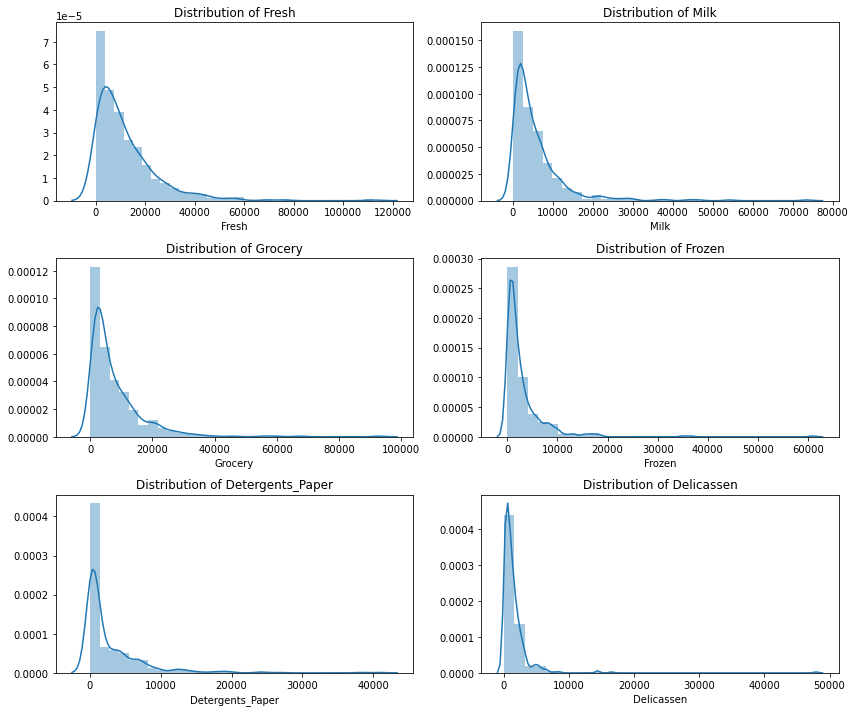

In [7]:
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

plt.figure(figsize=(12, 10))
for i, col in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.distplot(data[col], bins=30, kde=True, hist=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Feature Distributions

We visualized the distributions of each spending category using histograms with KDE curves. Most features are right-skewed, indicating that a small number of customers spend significantly more than the average in certain categories.

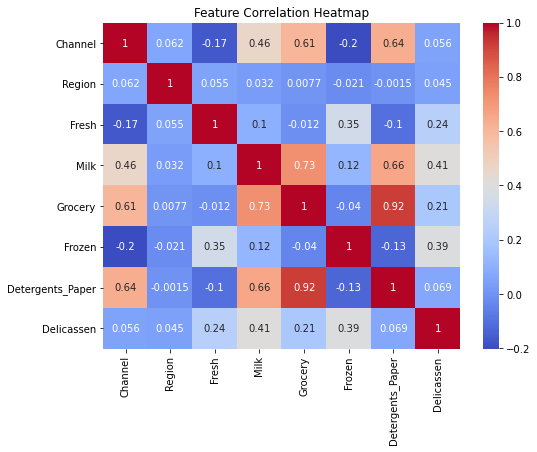

In [8]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Feature Correlations

We generated a heatmap to examine correlations between features. Strong positive correlations were found between Grocery, Milk, and Detergents_Paper. These relationships may affect clustering, as similar spending patterns might group customers into the same clusters.

In [9]:
X = data.drop(['Channel', 'Region'], axis=1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


Data Preprocessing

To prepare for clustering, we dropped non-informative columns like Channel and Region. We then applied standard scaling to normalize the data, ensuring that all features contribute equally during clustering.

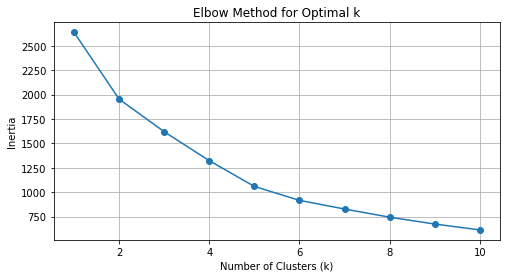

In [10]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Choosing the Optimal Number of Clusters

We used the Elbow Method to determine the optimal number of clusters. Based on the inflection point in the plot, we selected `k = 3` as the ideal number of clusters for this dataset.

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

data['Cluster'] = clusters

data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,0


KMeans Clustering

We applied KMeans clustering with `k = 3` and assigned the resulting cluster labels to the original dataset. Each customer is now associated with a cluster, representing their overall spending behavior across categories.

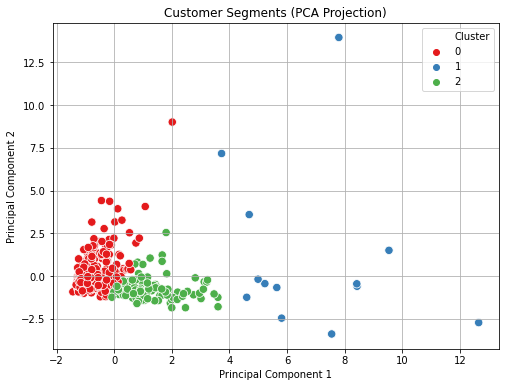

In [12]:
#pca visualization 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=70)
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Cluster Visualization

To visualize the customer segments, we applied PCA to reduce the scaled data to two dimensions. The resulting scatter plot shows three distinct clusters, supporting the segmentation achieved through KMeans.